<a href="https://colab.research.google.com/github/paulsu926/supersupao/blob/main/%E5%8F%B0%E6%8C%87%E6%9C%9F_CTA_%E5%9B%9E%E6%B8%AC%E6%A1%86%E6%9E%B6(%E5%AD%B8%E5%93%A1%E7%89%88).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 台指期 CTA 回測框架

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
from google.colab import files

plt.style.use('ggplot')
# pd.set_option('display.max_rows', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path ='/content/drive/My Drive/TXF_1m.csv'
df = pd.read_csv(file_path)
df.head(3)


,Unnamed: 0,datetime,Open,High,Low,Close,Volume,Date,Time
0,0,2010-01-04 08:46:00,8203.0,8208.0,8184.0,8187.0,1108,2010-01-04,08:46:00
1,1,2010-01-04 08:47:00,8187.0,8195.0,8186.0,8193.0,429,2010-01-04,08:47:00
2,2,2010-01-04 08:48:00,8194.0,8201.0,8193.0,8200.0,419,2010-01-04,08:48:00


## 資料整理
1. resample的bug?
    * 交易時間需整除，不然最後一根K看的長度會不一樣 => 1m, 3m, 5m, 10m, 15m, 30m, 60m, 1D
    * reample 1H，通常是從00:00記錄到00:00
    * resample後，沒有交易的時段會有NAN
    * 如果用K棒數來數分K：
        * 有時候夜盤沒交易的時段沒有值，會算錯根數
        * 結算日早盤交易時間少15分鐘，會算到夜盤
    * resample時間前歸後歸、開區間/閉區間的問題 (resample 參數中的 'close', 'label')
2. 台指期特殊處理
    * 台指期通常慣用結束時間紀錄分K (幣圈是使用開始時間)
    * 2017-5開始有夜盤
    * 分成日盤、日夜盤兩種交易時間
    * 結算日早盤交易時間少15分鐘
    * 每月第三個禮拜三為結算日
    * 交易時段：
        * 日盤：8:46~13:45
        * 夜盤：15:01~5:00

In [ ]:
df.index = pd.to_datetime(df['datetime'])
df.sort_index(inplace=True)
df = df.drop(columns=['Date', 'Time', 'datetime', 'Unnamed: 0'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['Hour'] = df.index.hour
df.head(3)

,open,high,low,close,volume,Hour
datetime,,,,,,
2010-01-04 08:46:00,8203.0,8208.0,8184.0,8187.0,1108,8
2010-01-04 08:47:00,8187.0,8195.0,8186.0,8193.0,429,8
2010-01-04 08:48:00,8194.0,8201.0,8193.0,8200.0,419,8


### 觀察資料

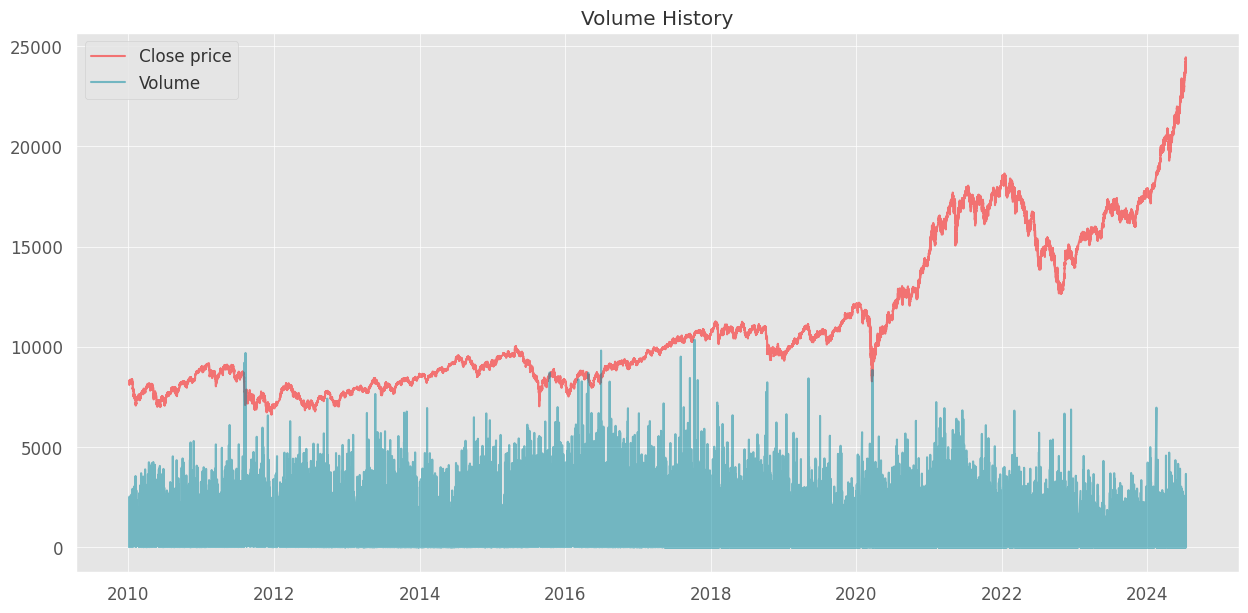

In [ ]:
plt.figure(figsize = (15,7))
plt.plot(df['close'], color = 'red', alpha = 0.5, label = 'Close price')
plt.plot(df['volume'], color = '#01889f', alpha = 0.5, label = 'Volume')
plt.legend(loc='upper left')
plt.title('Volume History');

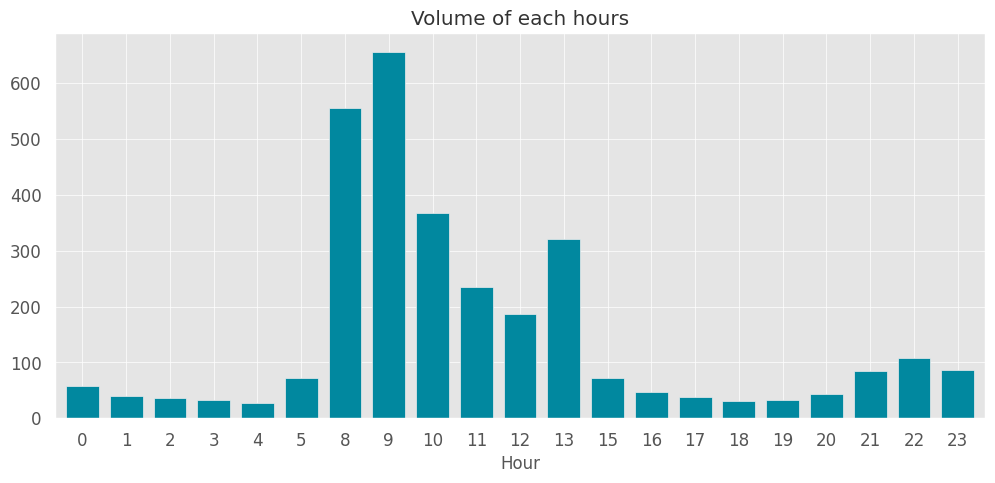

In [ ]:
data = df[(df.index >= '2017-05-15 00:00:00')].copy()
plt.figure(figsize = (12,5))
data.groupby(['Hour'])['volume'].mean().plot(kind='bar', width=0.75, color='#01889f')
plt.xticks(rotation = 0)
plt.title('Volume of each hours');

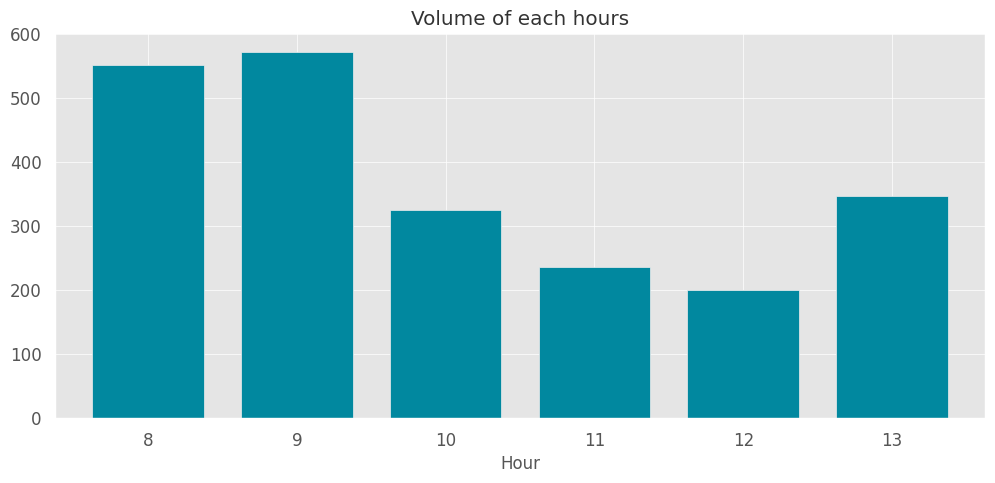

In [ ]:
data = df[(df.index < '2017-05-15 00:00:00')].copy()
plt.figure(figsize = (12,5))
data.groupby(['Hour'])['volume'].mean().plot(kind='bar', width=0.75, color='#01889f')
plt.xticks(rotation = 0)
plt.title('Volume of each hours');

### reample
* 注意
    * 台指期的 9:01 是指 9:00 ~ 9:01
    * 因此 9:03 的 3分K 應為 9:01 ~ 9:03
    * label='left' 顯示方式轉為整點開始
    * **日K 需要特別處理**
        * 時間直接減 8hr，再做 resample 即可
        * 時間要往後加一天，才不會用到未來資料
            * 8/8 日K 會用到 8/9 的 5:00
            * 計算 8/8 當天報酬率，是從 8/8 8:45 ~ 8/9 5:00
            * 使用外部資料需特別小心，因此通常會加一天處理
        * 2017-5 之後才有夜盤 (日K 多了 14 小時)
            * 日K 資料若包含日夜盤，通常會回測 2017-5 之後的資料，不然K棒的資訊含量不同
            * 使用 2017-5 之前的資料，時間更長，但回測上可能需注意市場結構轉變
            * 或者直接不考慮夜盤計算日K，就不會遇到這些問題了

In [ ]:
rule = '3T'
Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)
Morning.iloc[0:10]

,open,high,low,close,volume,Hour
datetime,,,,,,
2010-01-04 09:01:00,8203.0,8208.0,8184.0,8187.0,1108,8
2010-01-04 09:02:00,8187.0,8195.0,8186.0,8193.0,429,8
2010-01-04 09:03:00,8194.0,8201.0,8193.0,8200.0,419,8
2010-01-04 09:04:00,8200.0,8203.0,8198.0,8200.0,295,8
2010-01-04 09:05:00,8200.0,8201.0,8195.0,8197.0,187,8
2010-01-04 09:06:00,8198.0,8200.0,8195.0,8197.0,219,8
2010-01-04 09:07:00,8197.0,8200.0,8195.0,8196.0,207,8
2010-01-04 09:08:00,8196.0,8199.0,8195.0,8197.0,167,8
2010-01-04 09:09:00,8197.0,8198.0,8196.0,8196.0,124,8


In [ ]:
# 確認 9:03 及 9:06 的 open 是 9:01 及 9:04 的 open
Morning.resample(rule=rule, closed='right', label='right').last()[['close']].iloc[0:3]

,close
datetime,
2010-01-04 09:03:00,8200.0
2010-01-04 09:06:00,8197.0
2010-01-04 09:09:00,8196.0


In [ ]:
# label='left' => 時間轉為左側時間
Morning.resample(rule=rule, closed='left', label='left').last()[['close']].iloc[0:3]

,close
datetime,
2010-01-04 09:00:00,8193.0
2010-01-04 09:03:00,8197.0
2010-01-04 09:06:00,8197.0


In [ ]:
rule = '60T'

Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)

d1 = Morning.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Morning.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Morning.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Morning.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Morning.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Morning = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Morning = df_Morning.dropna()
df_Morning.index = df_Morning.index - dt.timedelta(minutes=15)
df_Morning.head()

,open,high,low,close,volume
datetime,,,,,
2010-01-04 08:45:00,8203.0,8211.0,8181.0,8187.0,17247
2010-01-04 09:45:00,8187.0,8188.0,8101.0,8165.0,31531
2010-01-04 10:45:00,8167.0,8180.0,8158.0,8172.0,8859
2010-01-04 11:45:00,8172.0,8207.0,8167.0,8197.0,12329
2010-01-04 12:45:00,8198.0,8200.0,8165.0,8166.0,13915


In [ ]:
rule = '60T'

Night = df[(df['Hour'] < 8) | (df['Hour'] > 13)]

d1 = Night.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Night.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Night.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Night.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Night.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Night = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Night = df_Night.dropna()
df_Night.head()

,open,high,low,close,volume
datetime,,,,,
2017-05-15 15:00:00,10023.0,10034.0,10020.0,10033.0,925
2017-05-15 16:00:00,10032.0,10032.0,10028.0,10030.0,300
2017-05-15 17:00:00,10030.0,10030.0,10026.0,10027.0,137
2017-05-15 18:00:00,10026.0,10028.0,10025.0,10027.0,148
2017-05-15 19:00:00,10028.0,10030.0,10028.0,10030.0,40


In [ ]:
df_Day = pd.concat([df_Morning, df_Night], axis=0)
df_Day = df_Day.sort_index(ascending=True)
df_Day.head()

,open,high,low,close,volume
datetime,,,,,
2010-01-04 08:45:00,8203.0,8211.0,8181.0,8187.0,17247
2010-01-04 09:45:00,8187.0,8188.0,8101.0,8165.0,31531
2010-01-04 10:45:00,8167.0,8180.0,8158.0,8172.0,8859
2010-01-04 11:45:00,8172.0,8207.0,8167.0,8197.0,12329
2010-01-04 12:45:00,8198.0,8200.0,8165.0,8166.0,13915


In [ ]:
# ### 特例：日K處理 ###
# day = df.loc['2017-5-15':].copy()
# df_day.index = df_day.index - dt.timedelta(hours=8)

# d1 = df_day.resample(rule='1D', closed='right', label='left').first()[['open']]
# d2 = df_day.resample(rule='1D', closed='right', label='left').max()[['high']]
# d3 = df_day.resample(rule='1D', closed='right', label='left').min()[['low']]
# d4 = df_day.resample(rule='1D', closed='right', label='left').last()[['close']]
# d5 = df_day.resample(rule='1D', closed='right', label='left').sum()[['volume']]

# df_day = pd.concat([d1,d2,d3,d4,d5], axis=1)
# df_day = df_day.dropna()
# df_day.index = df_day.index + dt.timedelta(days=1) ##回測時結算日也要加一天
# df_day.tail()

### 選擇回測資料

In [ ]:
# df_Morning['Month'] = df_Morning.index.map(lambda x: x.month)
# df_Morning['Weekday'] = df_Morning.index.map(lambda x: x.weekday)+1
df_Morning['Hour'] = df_Morning.index.hour

In [ ]:
trainData = df_Morning[(df_Morning.index >= '2010-01-01 00:00:00') & (df_Morning.index <= '2022-06-30 00:00:00')].copy()
testData = df_Morning[(df_Morning.index >= '2022-07-01 00:00:00') & (df_Morning.index <= '2024-06-30 00:00:00')].copy()

In [ ]:
trainData.head(3)

,open,high,low,close,volume,Hour
datetime,,,,,,
2010-01-04 08:45:00,8203.0,8211.0,8181.0,8187.0,17247,8
2010-01-04 09:45:00,8187.0,8188.0,8101.0,8165.0,31531,9
2010-01-04 10:45:00,8167.0,8180.0,8158.0,8172.0,8859,10


In [ ]:
testData.tail(3)

,open,high,low,close,volume,Hour
datetime,,,,,,
2024-06-28 10:45:00,23082.0,23086.0,22960.0,23037.0,15946,10
2024-06-28 11:45:00,23038.0,23064.0,23011.0,23038.0,7580,11
2024-06-28 12:45:00,23039.0,23042.0,22954.0,22983.0,15303,12


### 取得結算日資料
* https://www.taifex.com.tw/cht/5/futIndxFSP

In [ ]:
file_path ='/content/drive/My Drive/settlementDate.csv'
settlementDate_ = pd.read_csv(file_path)
settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']
settlementDate_

,settlementDate,futures,settlementPrice
0,2024/07/26,202407W4,22069
1,2024/07/17,202407,23680
2,2024/07/10,202407W2,23996
3,2024/07/03,202407W1,23138
4,2024/06/26,202406W4,22965
...,...,...,...
740,1999/01/21,199901,6332
741,1998/12/17,199812,6695
742,1998/11/19,199811,7185
743,1998/10/22,199810,7068


In [ ]:
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']]

In [ ]:
len(list(settlementDate_[bool_]['futures']))

311

In [ ]:
12*25 + 4 + 7 # 1999~2023 共 25 年＊12個月，再加上 1998 年的9,10,11,12月期貨和今年的 1,2,3,4,5,6,7月期貨

311

In [ ]:
settlementDate = [i.replace('/','-') for i in list(settlementDate_[bool_]['settlementDate'])]

In [ ]:
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]

In [ ]:
settlementDate[-5:]

[datetime.date(1999, 1, 21),
 datetime.date(1998, 12, 17),
 datetime.date(1998, 11, 19),
 datetime.date(1998, 10, 22),
 datetime.date(1998, 9, 17)]

## 回測假設
* 換月轉倉：結算日當天直接平倉
* 進場限制：結算日當天不進場
* 報酬計算：200 * 點數
* 手續費+滑價：單邊 600元

In [ ]:
#參數設定
fund = 1000000
feePaid = 600
length = 15
NumStd = 1.5
K = 0.04

#指標計算
# trainData['H'] = trainData['high'].shift(1).rolling(window=length, center=False).max()
# trainData['L'] = trainData['low'].shift(1).rolling(window=length, center=False).min()
trainData['MA'] = trainData['close'].rolling(window=length, center=False).mean()
trainData['STD'] = trainData['close'].rolling(window=length, center=False).std()
trainData['upLine'] = trainData['MA'] + NumStd*trainData['STD']
trainData['downLine'] = trainData['MA'] - NumStd*trainData['STD']

trainData.tail(3)

,open,high,low,close,volume,Hour,MA,STD,upLine,downLine
datetime,,,,,,,,,,
2022-06-29 10:45:00,15083.0,15091.0,14994.0,15034.0,16523,10,15186.133333,130.383975,15381.709296,14990.557371
2022-06-29 11:45:00,15036.0,15066.0,15015.0,15051.0,11264,11,15190.466667,124.190445,15376.752334,15004.180999
2022-06-29 12:45:00,15051.0,15058.0,15007.0,15019.0,17675,12,15187.866667,127.525273,15379.154576,14996.578757


In [ ]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

#翻譯蒟蒻
# date_arr = []
# for i in time_arr:
#     date_arr.append(pd.to_datetime(i).date())

In [ ]:
date_arr

[datetime.date(2010, 1, 4),
 datetime.date(2010, 1, 4),
 datetime.date(2010, 1, 4),
 datetime.date(2010, 1, 4),
 datetime.date(2010, 1, 4),
 datetime.date(2010, 1, 5),
 datetime.date(2010, 1, 5),
 datetime.date(2010, 1, 5),
 datetime.date(2010, 1, 5),
 datetime.date(2010, 1, 5),
 datetime.date(2010, 1, 6),
 datetime.date(2010, 1, 6),
 datetime.date(2010, 1, 6),
 datetime.date(2010, 1, 6),
 datetime.date(2010, 1, 6),
 datetime.date(2010, 1, 7),
 datetime.date(2010, 1, 7),
 datetime.date(2010, 1, 7),
 datetime.date(2010, 1, 7),
 datetime.date(2010, 1, 7),
 datetime.date(2010, 1, 8),
 datetime.date(2010, 1, 8),
 datetime.date(2010, 1, 8),
 datetime.date(2010, 1, 8),
 datetime.date(2010, 1, 8),
 datetime.date(2010, 1, 11),
 datetime.date(2010, 1, 11),
 datetime.date(2010, 1, 11),
 datetime.date(2010, 1, 11),
 datetime.date(2010, 1, 11),
 datetime.date(2010, 1, 12),
 datetime.date(2010, 1, 12),
 datetime.date(2010, 1, 12),
 datetime.date(2010, 1, 12),
 datetime.date(2010, 1, 12),
 datetime.

### 做多

Buy Price: 8335.0, time: 2010-01-07T08:45:00.000000000
Sell Price: 8240.0, time: 2010-01-13T09:45:00.000000000
Trade completed

Buy Price: 8343.0, time: 2010-01-15T09:45:00.000000000
Sell Price: 8277.0, time: 2010-01-19T10:45:00.000000000
Trade completed

Buy Price: 7310.0, time: 2010-02-09T10:45:00.000000000
Sell Price: 7574.0, time: 2010-02-22T12:45:00.000000000
Trade completed

Buy Price: 7553.0, time: 2010-03-01T10:45:00.000000000
Sell Price: 7525.0, time: 2010-03-04T11:45:00.000000000
Trade completed

Buy Price: 7681.0, time: 2010-03-05T09:45:00.000000000
Sell Price: 7634.0, time: 2010-03-15T10:45:00.000000000
Trade completed

Buy Price: 7849.0, time: 2010-03-18T09:45:00.000000000
Sell Price: 7788.0, time: 2010-03-22T09:45:00.000000000
Trade completed

Buy Price: 7901.0, time: 2010-03-26T11:45:00.000000000
Sell Price: 7940.0, time: 2010-04-01T08:45:00.000000000
Trade completed

Buy Price: 8018.0, time: 2010-04-01T09:45:00.000000000
Sell Price: 8059.0, time: 2010-04-08T12:45:00.000

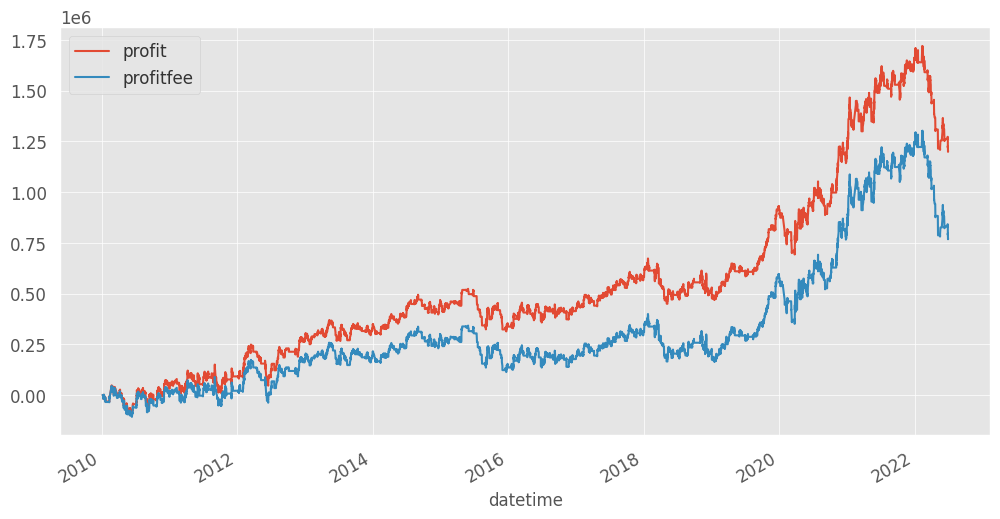

In [ ]:
#建立存放資料的單位
BS = None
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

#開始交易流程
for i in range(len(df_arr)):

    #回測期間最後一天就跳出這個迴圈
    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    ### 當收盤價突破布林上軌
    entryLong = df_arr[i,3] > df_arr[i,8]
    ### 結算日不進場
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    ### 當收盤價跌破布林下軌
    exitShort = df_arr[i,3] <= df_arr[i,9]
    ### 結算日時放到結算
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11

    #做多的狀態
    if BS == 'B':
      # 停利停損條件
      stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
      stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    #還沒進場不用計算損益
    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        #確認進場&相關設定
        if entryLong and entryCondition:
            #更改狀態至做多
            BS = 'B'
            #紀錄進場時間
            t = i+1
            buy.append(t)
            print("Buy Price: {}, time: {}".format(df_arr[t,0], time_arr[t]))

    #進場開始計算未實現損益
    elif BS == 'B':

        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)

        #近場條件達成，計算未實現損益-交易成本
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)

            #紀錄出場時間
            sell.append(i+1)

            #重置交易狀態
            BS = None
            print("Sell Price: {}, time: {}".format(df_arr[i+1,0], time_arr[i+1]))
            print("Trade completed")
            print()


            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)

        #出場條件未達成，計算未實現損益
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6));

In [ ]:
print(equity)

                        profit  profitfee
datetime                                 
2010-01-04 08:45:00        0.0        0.0
2010-01-04 09:45:00        0.0        0.0
2010-01-04 10:45:00        0.0        0.0
2010-01-04 11:45:00        0.0        0.0
2010-01-04 12:45:00        0.0        0.0
...                        ...        ...
2022-06-29 08:45:00  1198400.0   767600.0
2022-06-29 09:45:00  1211200.0   780400.0
2022-06-29 10:45:00  1211000.0   780200.0
2022-06-29 11:45:00  1201600.0   770800.0
2022-06-29 12:45:00  1204600.0   772600.0

[15343 rows x 2 columns]


### 做空

Streaming output truncated to the last 5000 lines.
buytocover at 2020-05-13T10:45:00.000000000
trade completed

sell short at 2020-05-13T11:45:00.000000000
buytocover at 2020-05-13T12:45:00.000000000
trade completed

sell short at 2020-05-14T08:45:00.000000000
buytocover at 2020-05-14T09:45:00.000000000
trade completed

sell short at 2020-05-14T10:45:00.000000000
buytocover at 2020-05-14T11:45:00.000000000
trade completed

sell short at 2020-05-14T12:45:00.000000000
buytocover at 2020-05-15T08:45:00.000000000
trade completed

sell short at 2020-05-15T09:45:00.000000000
buytocover at 2020-05-15T10:45:00.000000000
trade completed

sell short at 2020-05-15T11:45:00.000000000
buytocover at 2020-05-15T12:45:00.000000000
trade completed

sell short at 2020-05-18T08:45:00.000000000
buytocover at 2020-05-18T09:45:00.000000000
trade completed

sell short at 2020-05-18T10:45:00.000000000
buytocover at 2020-05-18T11:45:00.000000000
trade completed

sell short at 2020-05-18T12:45:00.000000000
buyt

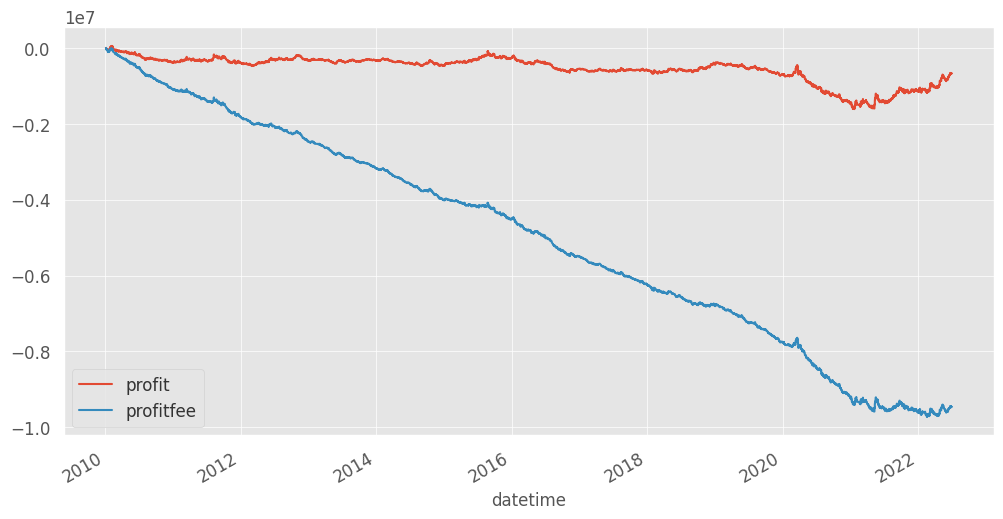

In [ ]:
BS = None
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    entrySellShort = "Put your answer in the blank!"
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    exitBuyToCover = "Put your answer in the blank!"
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11

    if BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            print("sell short at {}".format(time_arr[t]))


    elif BS == 'S':
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)

        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS = None
            print("buytocover at {}".format(time_arr[i+1]))
            print("trade completed")
            print()

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6));

### 多空都做(回家看)

Enter Long Position
Buy Price: 8335.0, time: 2010-01-07T08:45:00.000000000
Sell Price: 8240.0, time: 2010-01-13T09:45:00.000000000
Trade completed

Enter Short Position
Sell Price: 8221.0, time: 2010-01-13T10:45:00.000000000
Buycover Price: 8343.0, time: 2010-01-15T09:45:00.000000000
Trade completed

Enter Long Position
Buy Price: 8379.0, time: 2010-01-15T11:45:00.000000000
Sell Price: 8277.0, time: 2010-01-19T10:45:00.000000000
Trade completed

Enter Short Position
Sell Price: 8260.0, time: 2010-01-19T11:45:00.000000000
Buycover Price: 8240.0, time: 2010-01-20T12:45:00.000000000
Trade completed

Enter Short Position
Sell Price: 8126.0, time: 2010-01-21T10:45:00.000000000
Buycover Price: 7747.0, time: 2010-01-26T10:45:00.000000000
Trade completed

Enter Short Position
Sell Price: 7675.0, time: 2010-01-26T11:45:00.000000000
Buycover Price: 7232.0, time: 2010-02-05T09:45:00.000000000
Trade completed

Enter Short Position
Sell Price: 7232.0, time: 2010-02-05T10:45:00.000000000
Buycover Pr

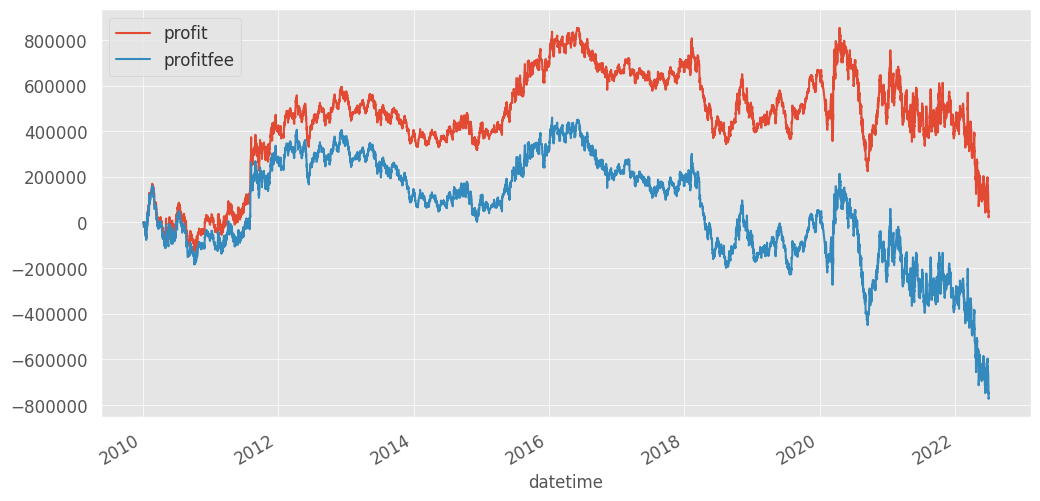

In [ ]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
rets = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    entryLong = df_arr[i,3] > df_arr[i,8]
    entrySellShort = df_arr[i,3] < df_arr[i,9]
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    exitShort = df_arr[i,3] <= df_arr[i,9]
    exitBuyToCover = df_arr[i,3] >= df_arr[i,8]
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11

    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)
            print("Enter Long Position")
            print("Buy Price: {}, time: {}".format(df_arr[t,0], time_arr[t]))

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            print("Enter Short Position")
            print("Sell Price: {}, time: {}".format(df_arr[t,0], time_arr[t]))

    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)

        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            print("Sell Price: {}, time: {}".format(df_arr[i+1,0], time_arr[i+1]))
            print("Trade completed")
            print()

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif BS == 'S':
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)

        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS = None
            print("Buycover Price: {}, time: {}".format(df_arr[i+1,0], time_arr[i+1]))
            print("Trade completed")
            print()

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6));

In [ ]:
print(equity)

                      profit  profitfee
datetime                               
2010-01-04 08:45:00      0.0        0.0
2010-01-04 09:45:00      0.0        0.0
2010-01-04 10:45:00      0.0        0.0
2010-01-04 11:45:00      0.0        0.0
2010-01-04 12:45:00      0.0        0.0
...                      ...        ...
2022-06-29 08:45:00  22400.0  -773200.0
2022-06-29 09:45:00  35200.0  -760400.0
2022-06-29 10:45:00  35000.0  -760600.0
2022-06-29 11:45:00  25600.0  -770000.0
2022-06-29 12:45:00  28600.0  -768200.0

[15343 rows x 2 columns]


### 做多加碼

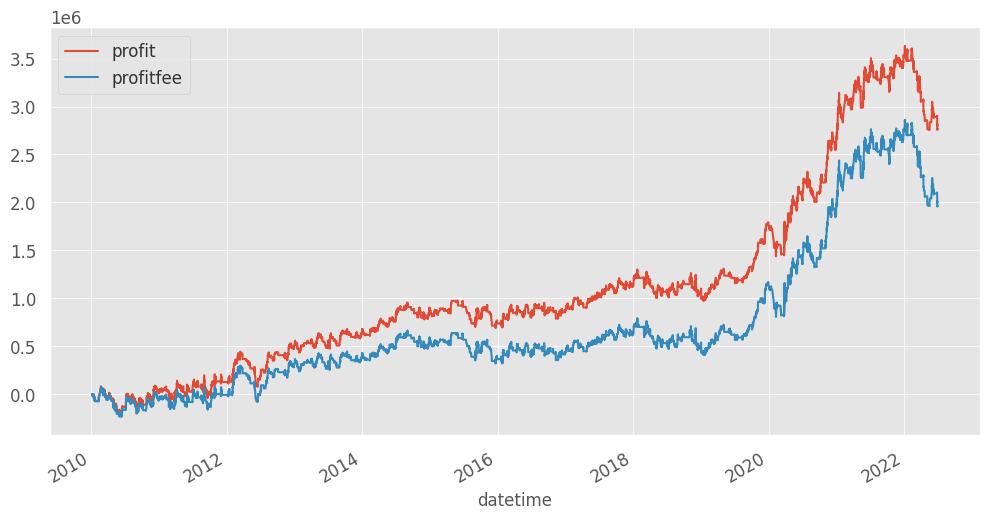

In [ ]:
BS = None
Position = 0
buy_price = 0
add_price = 0
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
cost_list = []
rets = []

for i in range(len(df_arr)):

    #回測期間最後一天就跳出這個迴圈
    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    #當收盤價突破布林上軌
    entryLong = df_arr[i,3] > df_arr[i,8]
    #結算日不進場
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    ### 當收盤價跌破布林下軌
    exitShort = df_arr[i,3] <= df_arr[i,9]
    ### 結算日時放到結算
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11


    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
        #做多狀態的加碼條件
        add_condition = df_arr[i, 0] > buy_price

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if (BS == None) & (Position == 0):

        profit_list.append(0)
        profit_fee_list.append(0)

        if entryLong and entryCondition:
            BS = 'B'
            Position = 1
            t = i+1
            buy_price = df_arr[i+1, 0]
            #將第一次進場成本紀錄在這個list中
            cost_list.append(buy_price)
            buy.append(t)

    elif BS == 'B':

        profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) * Position
        profit_list.append(profit)


        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            if Position > 1:
              pl_round = 200 * ((Position*df_arr[i+1,0]) - np.sum(cost_list[-2:]))
            else:
              pl_round = 200 * ((Position*df_arr[i+1,0]) - cost_list[-1])
            profit_fee = profit - feePaid*2*Position
            profit_fee_list.append(profit_fee)
            sell.append(i+1)

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*Position
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))
            #重置交易狀態
            BS = None
            #重置部位數量
            Position = 0
            #重置加碼參考價
            buy_price = 0
            #重置加碼成本
            add_price = 0


        #確認部位上限&加碼條件成立
        elif (Position <= 1) & add_condition:
            #更改部位數量
            add_price = df_arr[i+1, 0]
            #將第一次進場成本紀錄在這個list中
            cost_list.append(add_price)
            Position += 1

            profit_fee = profit
            profit_fee_list.append(profit_fee)

#             print("time: {}, Buy price: {} < Market Price: {}".format(time_arr[i], buy_price, df_arr[i, 0]))
#             print("add position at {}, {}".format(time_arr[i+1], df_arr[i+1, 0]))
#             print()

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6));

In [ ]:
print(equity)

                        profit  profitfee
datetime                                 
2010-01-04 08:45:00        0.0        0.0
2010-01-04 09:45:00        0.0        0.0
2010-01-04 10:45:00        0.0        0.0
2010-01-04 11:45:00        0.0        0.0
2010-01-04 12:45:00        0.0        0.0
...                        ...        ...
2022-06-29 08:45:00  2756400.0  1957200.0
2022-06-29 09:45:00  2782000.0  1982800.0
2022-06-29 10:45:00  2781600.0  1982400.0
2022-06-29 11:45:00  2762800.0  1963600.0
2022-06-29 12:45:00  2768800.0  1967200.0

[15343 rows x 2 columns]


### 做空加碼

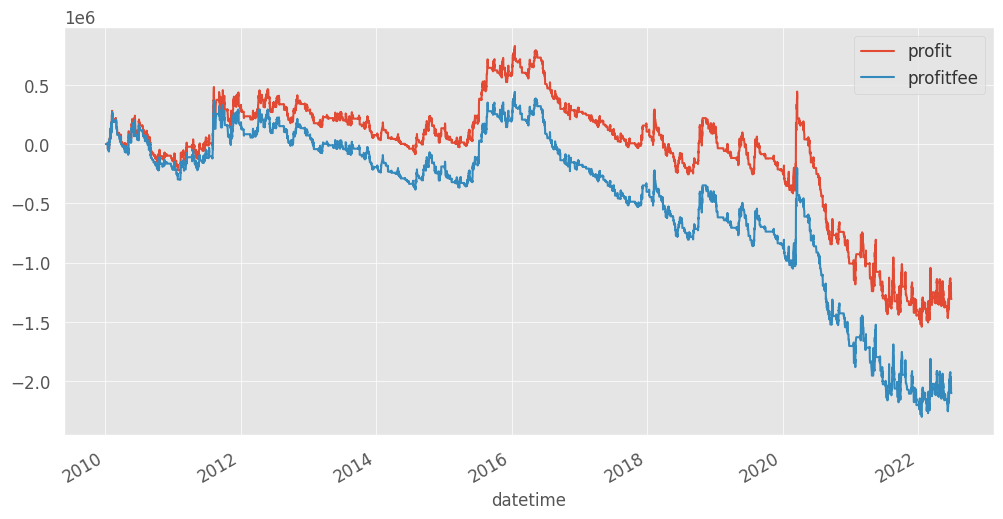

In [ ]:
BS = None
Position = 0
sell_price = 0
add_price = 0
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
cost_list = []
rets = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    entrySellShort = df_arr[i,3] < df_arr[i,9]
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    exitBuyToCover = df_arr[i,3] >= df_arr[i,8]
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11

    if BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)
        add_condition = df_arr[i, 0] < sell_price

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if (BS == None) and (Position == 0):

        profit_list.append(0)
        profit_fee_list.append(0)

        if entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            Position = 1
            sell_price  = df_arr[i+1, 0]
            cost_list.append(sell_price)
            sellshort.append(t)

    elif BS == 'S':

        profit = 200 * (df_arr[i,0] - df_arr[i+1,0]) * Position
        profit_list.append(profit)

        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            """
            There is something you need to do
            """
            profit_fee = profit - (feePaid*2 * Position)
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*Position
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

            BS = None
            Position = 0
            sell_price = 0
            add_price = 0

        #確認部位上限&加碼條件成立
        elif (Position <= 1) & add_condition:
            #更改部位數量
            add_price = df_arr[i+1, 0]
            cost_list.append(add_price)
            Position += 1

            profit_fee = profit
            profit_fee_list.append(profit_fee)

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6));

### 都做加碼（回家看）

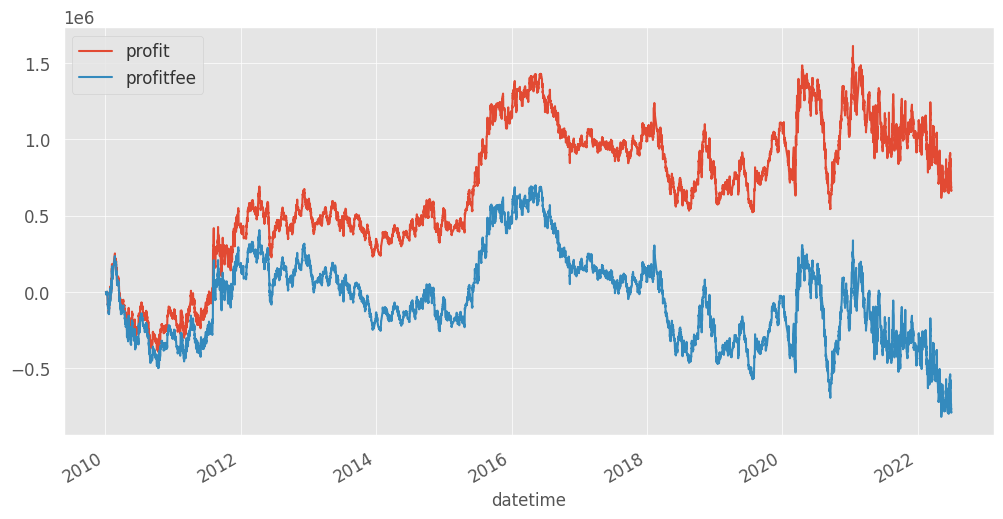

In [ ]:
BS = None
Position = 0
buy_price = 0
sell_price = 0
add_price = 0
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
cost_list = []
rets = []

for i in range(len(df_arr)):

    #回測期間最後一天就跳出這個迴圈
    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    ### 當收盤價突破布林上軌
    entryLong = df_arr[i,3] > df_arr[i,8]
    ### 當收盤價跌破布林下軌
    entrySellShort = df_arr[i,3] < df_arr[i,9]
    ### 結算日不進場
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    ### 當收盤價跌破布林下軌
    exitShort = df_arr[i,3] <= df_arr[i,9]
    #當收盤價突破布林上軌
    exitBuyToCover = df_arr[i,3] >= df_arr[i,8]

    ### 結算日時放到結算
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11


    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
        add_condition = df_arr[i, 0] > buy_price

    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)
        add_condition = df_arr[i, 0] < sell_price


#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if (BS == None) & (Position == 0):
        profit_list.append(0)
        profit_fee_list.append(0)

        if entryLong and entryCondition:
            BS = 'B'
            Position = 1
            t = i+1
            buy_price = df_arr[i+1, 0]
            cost_list.append(buy_price)
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            Position = 1
            sell_price  = df_arr[i+1, 0]
            cost_list.append(sell_price)
            sellshort.append(t)


    elif BS == 'B':

        profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) * Position
        profit_list.append(profit)

        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (Position*df_arr[i+1, 0] - np.sum(cost_list))
            profit_fee = profit - feePaid*2*Position
            profit_fee_list.append(profit_fee)
            sell.append(i+1)

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*Position
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

            BS = None
            Position = 0
            buy_price = 0
            add_price = 0
            cost_list = []

        #確認部位上限&加碼條件成立
        elif (Position <= 1) & add_condition:
            #更改部位數量
            add_price = df_arr[i+1, 0]
            cost_list.append(add_price)
            Position += 1

            profit_fee = profit
            profit_fee_list.append(profit_fee)

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif BS == 'S':

        profit = 200 * (df_arr[i,0] - df_arr[i+1,0]) * Position
        profit_list.append(profit)

        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (np.sum(cost_list) - Position*df_arr[i+1, 0])
            profit_fee = profit - feePaid*2*Position
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)

            #Realized PnL
            profit_fee_realized = pl_round - feePaid*2*Position
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

            BS = None
            Position = 0
            sell_price = 0
            add_price = 0
            cost_list = []

        #確認部位上限&加碼條件成立
        elif (Position <= 1) & add_condition:
            #更改部位數量
            add_price = df_arr[i+1, 0]
            cost_list.append(add_price)
            Position += 1

            profit_fee = profit
            profit_fee_list.append(profit_fee)

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6));

**績效呈現**\
1.基本指標\
2.時間損益\
3.損益分布\
4.quantstat套件

In [ ]:
import seaborn as sns
import matplotlib.pyplot as py
plt.style.use('ggplot')

In [ ]:
print(equity)

                       profit  profitfee
datetime                                
2010-01-04 08:45:00       0.0        0.0
2010-01-04 09:45:00       0.0        0.0
2010-01-04 10:45:00       0.0        0.0
2010-01-04 11:45:00       0.0        0.0
2010-01-04 12:45:00       0.0        0.0
...                       ...        ...
2022-06-29 08:45:00  661600.0  -791600.0
2022-06-29 09:45:00  674400.0  -778800.0
2022-06-29 10:45:00  674200.0  -779000.0
2022-06-29 11:45:00  664800.0  -788400.0
2022-06-29 12:45:00  667800.0  -786600.0

[15343 rows x 2 columns]


In [ ]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() #前n個元素的最大值
#print(profit_fee_list_realized)
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy) + len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))

print('Profit : ',profit)
print('Return : ',ret)
print('Max DrawDown : ',mdd)
print('Caimar Ratio : ',calmarRatio)
print('Trade Times : ',tradeTimes)
print('Win Rate : ',winRate)
print('Profit Factor : ',profitFactor)

Profit :  -786600.0
Return :  -0.7866
Max DrawDown :  0.893286219081272
Caimar Ratio :  -0.8805688291139241
Trade Times :  1030
Win Rate :  0.3328313253012048
Profit Factor :  0.9581315136740581


<ipython-input-236-a8ded4c0f009>:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [ ]:
# 時間損益(年)
equity.index = pd.to_datetime(equity.index) #確保索引是datetime型態
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
year_ret = []
print(equity.index.year.unique())
for i in equity.index.year.unique():
    year_ret.append(equity[equity.index.year == i]['equity'].iloc[-1]/equity[equity.index.year == i]['equity'].iloc[0] - 1)

df = pd.DataFrame({'Return':year_ret},index = years)

# heatmap函式
py.figure(figsize=(10,1))
sns.heatmap(df.transpose(), annot=True, cmap='OrRd')
py.title('Return by year')
py.show()
print('')

# 時間損益(月)
group_data = equity.groupby([equity.index.year, equity.index.month])

month_ret = []
for group, data in group_data:
    month_ret.append(data['equity'].iloc[-1]/data['equity'].iloc[0] - 1)

month_ret_padded = np.append(month_ret, [np.nan] * (13*12 - len(month_ret)))
df = pd.DataFrame(np.array(month_ret_padded).reshape((13,12)), columns=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                    index = years)

print(df)
py.figure(figsize=(15,15))
sns.heatmap(df, annot=True, cmap='OrRd')
py.title('Return by month')
py.show()

In [ ]:
# 損益分布
print(rets)
sns.histplot(rets, kde=True)
py.xlabel('Return per trade')
py.ylabel('Frequency')
py.title('Profit Loss Distribution')
py.show()

In [ ]:
# quantstats回測報表
!pip install quantstats
import quantstats
ret = equity['equity'].pct_change(periods=1).dropna()
print(ret)
quantstats.reports.full(ret)
#quantstats.reports.html(ret,output='stats.html',title='backtest result',download_filename='result.html')

**策略參數最佳化**

In [ ]:
optimizationList = []
fund = 1000000
feePaid = 600
length = 15
NumStd = 1.5

# 最佳化參數：length & NumStd
for length in range(10,110,10):
    for stdTimes in np.arange(0.5, 3, 0.5):

        stdTimes = np.round(stdTimes,1)

        print('----------')
        print(f'length: {length}')
        print(f'stdTimes: {stdTimes}')

        trainData['MA'] = trainData['close'].rolling(window=length, center=False).mean()
        trainData['STD'] = trainData['close'].rolling(window=length, center=False).std()
        trainData['upLine'] = trainData['MA'] + stdTimes*trainData['STD']
        trainData['downLine'] = trainData['MA'] - stdTimes*trainData['STD']

        #df['ma'] = df['close'].rolling(window=length, center=False).mean()
        #df['std'] = df['close'].rolling(window=length, center=False).std()

        df_arr = np.array(trainData)
        time_arr = np.array(trainData.index)
        date_arr = [pd.to_datetime(i).date() for i in time_arr]

        BS = None
        Position = 0
        buy_price = 0
        add_price = 0
        buy = []
        sell = []
        profit_list = [0]
        profit_fee_list = [0]
        profit_fee_list_realized = []
        cost_list = []
        rets = []

        for i in range(len(df_arr)):

            #回測期間最後一天就跳出這個迴圈
            if i == len(df_arr)-1:
                break

            ## 進場邏輯
            #當收盤價突破布林上軌
            entryLong = df_arr[i,3] > df_arr[i,8]
            #結算日不進場
            entryCondition = date_arr[i] not in settlementDate

            ## 出場邏輯
            ### 當收盤價跌破布林下軌
            exitShort = df_arr[i,3] <= df_arr[i,9]
            ### 結算日時放到結算
            exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11


            ## 停利停損邏輯
            if BS == 'B':
                stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
                stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
                #做多狀態的加碼條件
                add_condition = df_arr[i, 0] > buy_price

        #     if exitCondition == True:
        #         print(f'{time_arr[i]}')

            if (BS == None) & (Position == 0):

                profit_list.append(0)
                profit_fee_list.append(0)

                if entryLong and entryCondition:
                    BS = 'B'
                    Position = 1
                    t = i+1
                    buy_price = df_arr[i+1, 0]
                    #將第一次進場成本紀錄在這個list中
                    cost_list.append(buy_price)
                    buy.append(t)

            elif BS == 'B':

                profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) * Position
                profit_list.append(profit)


                if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
                    if Position > 1:
                        pl_round = 200 * ((Position*df_arr[i+1,0]) - np.sum(cost_list[-2:]))
                    else:
                        pl_round = 200 * ((Position*df_arr[i+1,0]) - cost_list[-1])
                    profit_fee = profit - feePaid*2*Position
                    profit_fee_list.append(profit_fee)
                    sell.append(i+1)

                    # Realized PnL
                    profit_fee_realized = pl_round - feePaid*2*Position
                    profit_fee_list_realized.append(profit_fee_realized)
                    rets.append(profit_fee_realized/(200*df_arr[t,0]))
                    #重置交易狀態
                    BS = None
                    #重置部位數量
                    Position = 0
                    #重置加碼參考價
                    buy_price = 0
                    #重置加碼成本
                    add_price = 0


                #確認部位上限&加碼條件成立
                elif (Position <= 1) & add_condition:
                    #更改部位數量
                    add_price = df_arr[i+1, 0]
                    #將第一次進場成本紀錄在這個list中
                    cost_list.append(add_price)
                    Position += 1

                    profit_fee = profit
                    profit_fee_list.append(profit_fee)

        #             print("time: {}, Buy price: {} < Market Price: {}".format(time_arr[i], buy_price, df_arr[i, 0]))
        #             print("add position at {}, {}".format(time_arr[i+1], df_arr[i+1, 0]))
        #             print()

                else:
                    profit_fee = profit
                    profit_fee_list.append(profit_fee)


        equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
        equity['equity'] = equity['profitfee'] + fund
        equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
        equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
        ret = equity['equity'][-1]/equity['equity'][0] - 1
        mdd = abs(equity['drawdown_percent'].min())
        calmarRatio = ret / mdd

        optimizationList.append([length, stdTimes, ret, calmarRatio])

print(optimizationList)

In [ ]:
optResult = pd.DataFrame(optimizationList, columns=['length','stdTimes','ret','calmarRatio'])
optResult

In [ ]:
optResult[(optResult['stdTimes'] == 2)].sort_values('ret', ascending=False).iloc[:5]

In [ ]:
import plotly
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
pyo.init_notebook_mode()

import plotly.io as io
#io.renderers.default='browser'

In [ ]:
x = np.arange(10,110,10)
y = np.arange(0.5,3,0.5)
x1, y1 = np.meshgrid(x, y)
z = np.zeros((5,10))

for x in range(0,5):
    for y in range(0,10):
        filter1 = (optResult['length']==x1[x,y])
        filter2 = (optResult['stdTimes']==y1[x,y])
        #print(vol_quote[filter1][filter2]['Value'].values[0])
        z[x,y] = optResult[filter1][filter2]['ret'].values[0]
print(z)

fig = go.Figure(data=[go.Surface(x=x1, y=y1, z=z)])
fig.update_layout(title='Surface', autosize=False, width=500, height=500,
                          margin=dict(l=50, r=50, b=50, t=50))
#plotly.offline.plot(fig, filename='ret.html')
fig.show(renderer="colab")

In [ ]:
x = np.arange(10,110,10)
y = np.arange(0.5,3,0.5)
x1, y1 = np.meshgrid(x, y)
z = np.zeros((5,10))

for x in range(0,5):
    for y in range(0,10):
        filter1 = (optResult['length']==x1[x,y])
        filter2 = (optResult['stdTimes']==y1[x,y])
        #print(vol_quote[filter1][filter2]['Value'].values[0])
        z[x,y] = optResult[filter1][filter2]['calmarRatio'].values[0]

fig = go.Figure(data=[go.Surface(x=x1, y=y1, z=z)])
fig.update_layout(title='Surface', autosize=False, width=500, height=500,
                          margin=dict(l=50, r=50, b=50, t=50))
#plotly.offline.plot(fig, filename='calmarRation.html')
fig.show(renderer="colab")